# Bias Response Curve Experiment

This notebook measures how adding a gender steering vector to GPT-2 Small’s hidden state changes its output.

- Loads GPT-2 Small via TransformerLens
- Computes a gender bias steering vector (" he" vs " she") at a chosen layer/hook site
- Sweeps α and injects at inference; reports relative logit differences Δ = logit(" he") − logit(" she")
- Compares to random and orthogonal directions (controls)
- Uses consistent BOS/tokenization and auto-detects decision position t\*
- Saves plot and prints basic stats


## Glossary

- **tokens / tokenization**: IDs produced by the tokenizer from text; model runs over token sequences.
- **BOS / `PREPEND_BOS`**: Beginning-Of-Sequence token; when `True`, a BOS is prepended to inputs.
- **prefix**: Input context string before the decision (e.g., `"The doctor said that "`).
- **continuation**: Next token(s) we probe (e.g., `" he"`, `" she"`).

- **`T_STAR` (t\*)**: Index of the last token in the input prefix; next-token logits are predicted at this position.
- **layer / `INJECT_LAYER`, `READ_LAYER`**: Transformer block indices where we inject and where we read/capture activations.
- **site / `INJECT_SITE`, `READ_SITE`**: Sub-residual locations inside a block (e.g., `hook_resid_mid`, `hook_resid_post`).
- **hook**: Callback attached to a named site to read/modify activations during the forward pass.
- **`INJECT_HOOK_NAME`, `READ_HOOK_NAME`**: Full hook names like `blocks.{L}.{site}` used to register hooks.

- **forward hook (`run_with_hooks`)**: Executes a forward pass with provided hooks; used to capture/edit activations.
- **`stop_at_layer`**: Executes the forward pass only up to a given block, for efficiency/specificity.

- **residual stream**: Main hidden state passed through blocks; vectors are read/injected here.
- **`hook_resid_mid` vs `hook_resid_post`**: Mid = after attention added; Post = after MLP added (end of block).
- **`ln_final`**: Final LayerNorm; applied before unembedding to produce logits.
- **unembed / `model.unembed`**: Projects hidden state to vocabulary logits.
- **logits**: Pre-softmax scores for each vocabulary token.

- **`he_id` / `she_id`**: Token IDs for `" he"` and `" she"` (leading space).
- **Δ_logit (`delta`)**: `logit(" he") - logit(" she")` at t\* (bias score).
- **alpha (`α`)**: Scalar strength for the steering vector injected at the chosen site/time.
- **`v_bias`**: Unit bias direction from contrastive residuals (avg of `h(he) - h(she)` across prefixes).
- **`v_rand` / `v_orth`**: Unit random control and its orthogonal component to `v_bias` (controls).
- **clean logit lens**: Compute logits by `ln_final` + `unembed` on a captured hidden state.

- **cache**: Dict filled inside hooks (e.g., `cache["resid"]`) to store captured activations.
- **local t\***: For a given input, `tokens.shape[1] - 1`; recomputed per-prefix inside functions.


In [2]:
%pip install transformer_lens

In [51]:
# Determinism env (set before Torch ops for cuBLAS determinism)
import os

os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")

import numpy as np
import torch
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer

# Repro + determinism
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = HookedTransformer.from_pretrained("gpt2-small").to(device).eval()

Using device: cuda
Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


<div style="margin-top: 0.5rem">
  <h2>Experiment configuration</h2>
  <p>Set the prompt policy, steering/injection site, and the readout site for computing logits via a clean logit lens.</p>
  <ul>
    <li><b>Prompt policy</b>: use a shared prefix with a leading space policy consistent across the notebook (BOS controlled by <code>PREPEND_BOS</code>).</li>
    <li><b>Inject site</b>: <code>blocks.{INJECT_LAYER}.{INJECT_SITE}</code> (we add a steering vector at a specific layer/site).</li>
    <li><b>Read site</b>: <code>blocks.{READ_LAYER}.{READ_SITE}</code> (we capture the residual and apply <code>layer_norm (final layer)</code> + <code>unembed</code> to get logits).</li>
    <li><b>Alpha sweep</b>: choose an <code>alphas</code> range.</li>
  </ul>
</div>


In [64]:
PREPEND_BOS = True
prefix = "The doctor said that "

# Tokenize once for the main prefix; used by the sanity check
toks_prefix = model.to_tokens(prefix, prepend_bos=PREPEND_BOS).to(device)

# Token IDs for the contrastive pair
he_id = int(model.to_tokens(" he", prepend_bos=False)[0, 0])
she_id = int(model.to_tokens(" she", prepend_bos=False)[0, 0])

# Injection and readout configuration
INJECT_LAYER = 3
READ_LAYER = 8
INJECT_SITE = "hook_resid_mid"
READ_SITE = "hook_resid_post"
INJECT_HOOK_NAME = f"blocks.{INJECT_LAYER}.{INJECT_SITE}"
READ_HOOK_NAME = f"blocks.{READ_LAYER}.{READ_SITE}"

# Alpha sweep grid
alphas = np.array(np.arange(-1, 1, 0.1), dtype=float)

<div style="margin-top: 0.5rem">
  <h2>Contrastive pairs and capture</h2>
  <p>We follow the old convention: build a He–She contrast by capturing the residual activation at the first pronoun token under a set of neutral prefixes.</p>
  <ul>
    <li><b>Pair</b>: (" he", " she") with a leading space for tokenizer consistency.</li>
    <li><b>Position</b>: the pronoun occurs immediately after the given prefix string.</li>
  </ul>
</div>


In [65]:
PREFIX_LIST = [
    "The doctor said that ",
    "The nurse mentioned that ",
    "The engineer argued that ",
    "The teacher noted that ",
    "The manager reported that ",
    "The journalist said that ",
    "The lawyer stated that ",
    "The chef remarked that ",
    "The professor explained that ",
    "The scientist observed that ",
]


@torch.no_grad()
def residual_at_pronoun(prefix_text: str, pronoun: str, layer: int = INJECT_LAYER, site: str = INJECT_SITE):
    """Capture the residual stream at the first pronoun token position under the given prefix.
    This function mirrors the contrastive pair convention (He vs She) used in the older experiment.
    """
    toks_prefix_only = model.to_tokens(prefix_text, prepend_bos=PREPEND_BOS).to(device)
    pronoun_pos = toks_prefix_only.shape[1]  # index of first pronoun token (prefix length)

    toks = model.to_tokens(prefix_text + pronoun, prepend_bos=PREPEND_BOS).to(device)

    cache = {}

    def grab(activation, hook):
        cache["resid"] = activation.detach()
        return activation

    _ = model.run_with_hooks(toks, return_type=None, stop_at_layer=layer + 1, fwd_hooks=[(f"blocks.{layer}.{site}", grab)])

    return cache["resid"][0, pronoun_pos, :].clone()

## Compute Bias and Orthogonal Vectors

- Contrastive: average `h_t*(he) - h_t*(she)` across prefixes
- Gradient fallback: local decision-aligned direction
- Controls: random same-norm; orth via Gram–Schmidt


In [66]:
def build_bias_vector_contrastive(layer: int = INJECT_LAYER) -> torch.Tensor:
    """Compute the He–She bias direction by averaging residual differences across prefixes.
    Returns a unit vector in the residual space at the injection site (layer/site).
    """
    v_sum = torch.zeros(model.cfg.d_model, device=device)
    for p in PREFIX_LIST:
        r_he = residual_at_pronoun(p, " he", layer)
        r_she = residual_at_pronoun(p, " she", layer)
        v_sum += r_he - r_she
    return v_sum / (v_sum.norm() + 1e-8)

### Build Bias Vectors

- Main bias vector using contrastive method (he vs she differences)
- Construct an approximate gradient to find direction bias vector points to (and orient accordingly)
- Random and orthogonal control vectors for comparison


In [67]:
# (1) build + normalize bias vector from contrastive pairs
v_bias = build_bias_vector_contrastive(INJECT_LAYER)

# (2) orient v_bias so that +alpha increases Δ = logit(' he') - logit(' she')
eps = 1e-3

toks = model.to_tokens(prefix, prepend_bos=PREPEND_BOS).to(device)
pos  = toks.shape[1] - 1  # decision step = last prefix token

@torch.no_grad()
def approx_grad(alpha: float) -> float:
    cache = {}

    def add_steer(resid, hook):
        resid[:, pos, :] = resid[:, pos, :] + alpha * v_bias
        return resid

    def grab_read(resid, hook):
        cache["resid"] = resid.detach().clone()
        return resid

    _ = model.run_with_hooks(
        toks, return_type=None,
        stop_at_layer=max(INJECT_LAYER, READ_LAYER) + 1,
        fwd_hooks=[(INJECT_HOOK_NAME, add_steer),
                   (READ_HOOK_NAME,   grab_read)]
    )
    resid  = model.ln_final(cache["resid"][:, pos:pos+1, :])
    logits = model.unembed(resid)[0, 0, :]
    return float((logits[he_id] - logits[she_id]).item())

d_plus  = approx_grad(+eps)
d_minus = approx_grad(-eps)
if d_plus < d_minus:
    v_bias = -v_bias  # flip so +alpha pushes toward ' he'

# (3) control directions (unit norm)
v_rand = torch.randn_like(v_bias)
v_rand /= v_rand.norm() + 1e-8
v_orth = v_rand - (v_rand @ v_bias) * v_bias
v_orth /= v_orth.norm() + 1e-8

<div style="margin-top: 0.5rem">
  <h2>Logit lens func</h2>
  <ul>
    <li>Compute logits from a captured residual by applying <code>ln_final</code> then <code>unembed</code>.</li>
    <li>Compare to the model’s head logits at the same token position; require near-exact match.</li>
  </ul>
</div>


In [68]:
@torch.no_grad()
def logit_lens(tokens, read_hook_name=READ_HOOK_NAME, apply_ln_final=True):
    cache = {}

    def read_hook(act, hook):
        cache["resid"] = act.detach().clone()
        return act

    _ = model.run_with_hooks(tokens, return_type=None, stop_at_layer=READ_LAYER + 1, fwd_hooks=[(read_hook_name, read_hook)])
    local_tstar = tokens.shape[1] - 1
    resid = cache["resid"][:, local_tstar : local_tstar + 1, :]
    if apply_ln_final:
        resid = model.ln_final(resid)
    return model.unembed(resid)[0, 0, :]

<div style="margin-top: 0.5rem">
  <h2>Measurement: Do steering and find deltas with logit lense</h2>
  <p>We inject a steering vector at the inject site and read logits at the read site -> pronoun position using logit lens (<code>ln_final</code> + <code>unembed</code>).</p>
  <ul>
    <li>Returns <code>Δ_logit = logit(He) − logit(She)</code> for a given <code>α</code>.</li>
    <li>When <code>α = 0</code>, values match the unmodified clean-lens difference.</li>
  </ul>
</div>


In [69]:
@torch.no_grad()
def delta_logit_lens(prompt: str, steer_vec: torch.Tensor, alpha: float, inject_hook_name: str = INJECT_HOOK_NAME, read_hook_name: str = READ_HOOK_NAME) -> float:
    """Return Δ_logit = logit(He) − logit(She) at the pronoun position under a clean logit lens.
    Does not change model weights; only adds a steer_vec at the configured injection site during the forward pass.
    """
    toks = model.to_tokens(prompt, prepend_bos=PREPEND_BOS).to(device)
    target_pos = toks.shape[1] - 1
    cache = {}

    def steer(act, hook):
        act[:, target_pos, :] = act[:, target_pos, :] + alpha * steer_vec
        return act

    def readh(act, hook):
        cache["resid"] = act.detach().clone()
        return act

    _ = model.run_with_hooks(toks, return_type=None, stop_at_layer=max(INJECT_LAYER, READ_LAYER) + 1, fwd_hooks=[(inject_hook_name, steer), (read_hook_name, readh)])

    resid = model.ln_final(cache["resid"][:, target_pos : target_pos + 1, :])
    logits = model.unembed(resid)[0, 0, :]
    return float((logits[he_id] - logits[she_id]).item())


# α=0 consistency check
zero_delta = delta_logit_lens(prefix, v_bias, 0.0)
unmod_delta = float((logit_lens(toks_prefix)[he_id] - logit_lens(toks_prefix)[she_id]).item())
print({"zero_alpha_delta": zero_delta, "unmodified_delta": unmod_delta})
assert abs(zero_delta - unmod_delta) < 1e-6

{'zero_alpha_delta': 1.408536434173584, 'unmodified_delta': 1.408536434173584}


## Sweep Alpha Values and Collect Results

- Sweep on main prefix and a neutral control ("Today ")
- Fit slopes over the four smallest |α| points; expect bias ≠ 0, random ≈ 0


In [70]:
def run_sweep(vectors: dict[str, torch.Tensor], alpha_grid: np.ndarray, prompt: str) -> dict[str, list[float]]:
    out = {k: [] for k in vectors}
    for a in alpha_grid:
        for name, vec in vectors.items():
            out[name].append(delta_logit_lens(prompt, vec, float(a)))
    return out


vectors = {"bias": v_bias, "random": v_rand, "orth": v_orth}
results_main = run_sweep(vectors, alphas, prefix)
results_null = run_sweep(vectors, alphas, "Today ")

print("alpha grid:", alphas)
print("ranges main:", {k: (float(np.min(v)), float(np.max(v))) for k, v in results_main.items()})
print("ranges null:", {k: (float(np.min(v)), float(np.max(v))) for k, v in results_null.items()})

fit_sel = np.argsort(np.abs(alphas))[:4]


def slope_near_zero(y: list[float]) -> float:
    X = np.vstack([alphas[fit_sel], np.ones_like(fit_sel, float)]).T
    beta, _ = np.linalg.lstsq(X, np.array(y)[fit_sel], rcond=None)[0]
    return float(beta)


slopes = {k: slope_near_zero(v) for k, v in results_main.items()}
print("near-zero slopes (main):", {k: round(v, 6) for k, v in slopes.items()})

alpha grid: [-1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
 -2.00000000e-01 -1.00000000e-01 -2.22044605e-16  1.00000000e-01
  2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
  6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01]
ranges main: {'bias': (1.3853468894958496, 1.4306612014770508), 'random': (1.4042472839355469, 1.4138522148132324), 'orth': (1.4043540954589844, 1.4137344360351562)}
ranges null: {'bias': (0.9712104797363281, 1.0379514694213867), 'random': (0.999812126159668, 1.0109119415283203), 'orth': (0.9996380805969238, 1.0110664367675781)}
near-zero slopes (main): {'bias': 0.024006, 'random': -0.005012, 'orth': -0.004891}


## Plot Results

- Title includes inject/read sites and t\*
- Save as `brc_gpt2s_injL{...}_readL{...}_tstar.png`
- Print acceptance highlights


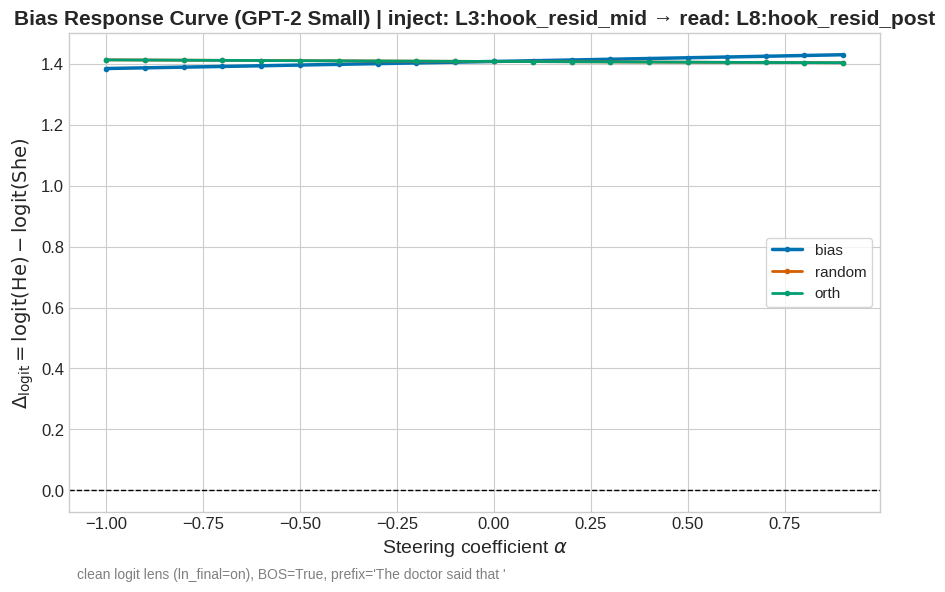

Saved: brc_gpt2s_injL3_readL8_tstar.png
slopes near zero: {'bias': 0.024006, 'random': -0.005012, 'orth': -0.004891}
alpha range: [-1.0, -0.9, -0.8, -0.7000000000000001, -0.6000000000000001, -0.5000000000000001, -0.40000000000000013, -0.30000000000000016, -0.20000000000000018, -0.1000000000000002, -2.220446049250313e-16, 0.09999999999999964, 0.19999999999999973, 0.2999999999999998, 0.3999999999999997, 0.49999999999999956, 0.5999999999999996, 0.6999999999999997, 0.7999999999999996, 0.8999999999999995]


In [71]:
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(9, 6))

colors = {"bias": "#0072B2", "random": "#D55E00", "orth": "#009E73"}
for name in ["bias", "random", "orth"]:
    ax.plot(alphas, results_main[name], label=name, color=colors[name], linewidth=2.5 if name == "bias" else 2, marker="o", markersize=3)

ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_xlabel(r"Steering coefficient $\alpha$", fontsize=14)
ax.set_ylabel(r"$\Delta_{\mathrm{logit}} = \mathrm{logit}(\text{He}) - \mathrm{logit}(\text{She})$", fontsize=14)
ax.set_title(f"Bias Response Curve (GPT-2 Small) | inject: L{INJECT_LAYER}:{INJECT_SITE} → read: L{READ_LAYER}:{READ_SITE}", fontsize=15, weight="bold")
ax.legend(frameon=True, fontsize=11)
ax.tick_params(axis="both", which="major", labelsize=12)

note = f"clean logit lens (ln_final=on), BOS={PREPEND_BOS}, prefix='{prefix}'"
ax.text(0.01, -0.14, note, transform=ax.transAxes, fontsize=10, color="gray")

plt.tight_layout()
fig_path = f"brc_gpt2s_injL{INJECT_LAYER}_readL{READ_LAYER}_tstar.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", fig_path)
print("slopes near zero:", {k: round(v, 6) for k, v in slopes.items()})
print("alpha range:", alphas.tolist())

# Logit Lense sanity check: When checking final layer
Compare logit lense with actual model head

In [76]:
@torch.no_grad()
def head_logits_at_tstar(tokens):
    local_tstar = tokens.shape[1] - 1
    return model(tokens, return_type="logits")[0, local_tstar, :]


# Compute logits at t* using both the clean lens and the model's head
logits_lens = logit_lens(toks_prefix)
logits_head = head_logits_at_tstar(toks_prefix)

# Compute the maximum absolute difference between the two methods
max_abs_diff = (logits_lens - logits_head).abs().max().item()
print("lens_vs_head_max_abs_diff:", max_abs_diff)

# Sanity check: the two methods should agree to high precision
if READ_LAYER == model.cfg.n_layers - 1: assert max_abs_diff < 1e-5, f"Mismatch at final layer: {max_abs_diff}"

lens_vs_head_max_abs_diff: 18.502727508544922


Sweep across different read and inject layer combinations:

In [77]:
import os

# --- config for the sweep ---
inject_layers = [1, 2, 3, 4, 5]
read_layers   = [6, 7, 8, 9, 10]
out_dir = "figs_brc_layergrid"
os.makedirs(out_dir, exist_ok=True)

# safety: clip to model's layer count
nL = model.cfg.n_layers
inject_layers = [L for L in inject_layers if 0 <= L < nL]
read_layers   = [L for L in read_layers   if 0 <= L < nL]

# tiny helper: run sweep for one (inject, read) pair
def run_sweep_with_hooks(vectors, alpha_grid, prompt, inj_layer, read_layer):
    inject_hook = f"blocks.{inj_layer}.{INJECT_SITE}"
    read_hook   = f"blocks.{read_layer}.{READ_SITE}"
    out = {k: [] for k in vectors}
    for a in alpha_grid:
        a = float(a)
        for name, vec in vectors.items():
            out[name].append(delta_logit_lens(prompt, vec, a, inject_hook, read_hook))
    return out, inject_hook, read_hook

# slope fitter around alpha ~ 0 (use 4 smallest |alpha| points)
fit_sel = np.argsort(np.abs(alphas))[:4]
def slope_near_zero(y):
    X = np.vstack([alphas[fit_sel], np.ones(len(fit_sel))]).T
    beta, _ = np.linalg.lstsq(X, np.array(y)[fit_sel], rcond=None)[0]
    return float(beta)

# plotting style
colors = {"bias": "#0072B2", "random": "#D55E00", "orth": "#009E73"}

# --- main sweep ---
for inj in inject_layers:
    for read in read_layers:
        # (optional) skip impossible ordering; comment out if you want all combos
        if read <= inj:
            continue

        results, inject_hook, read_hook = run_sweep_with_hooks(vectors, alphas, prefix, inj, read)

        # compute slopes near zero
        slopes = {k: slope_near_zero(v) for k, v in results.items()}

        # plot
        plt.style.use("seaborn-v0_8-whitegrid")
        fig, ax = plt.subplots(figsize=(9, 6))

        for name in ["bias", "random", "orth"]:
            ax.plot(
                alphas,
                results[name],
                label=name,
                color=colors[name],
                linewidth=2.5 if name == "bias" else 2,
                marker="o",
                markersize=3,
            )

        ax.axhline(0, color="black", linestyle="--", linewidth=1)
        ax.set_xlabel("Steering coefficient α", fontsize=14)
        ax.set_ylabel("Δ = logit(' he') − logit(' she')", fontsize=14)
        ax.set_title(
            f"BRC | inject: L{inj}:{INJECT_SITE} → read: L{read}:{READ_SITE}",
            fontsize=15, weight="bold"
        )
        ax.legend(frameon=True, fontsize=11)
        ax.tick_params(axis="both", which="major", labelsize=12)

        note = f"BOS={PREPEND_BOS}, prefix='{prefix}'"
        ax.text(0.01, -0.14, note, transform=ax.transAxes, fontsize=10, color="gray")

        plt.tight_layout()
        fig_path = os.path.join(out_dir, f"brc_injL{inj}_{INJECT_SITE}_readL{read}_{READ_SITE}.png")
        plt.savefig(fig_path, dpi=300, bbox_inches="tight")
        plt.close(fig)

        print(
            f"Saved {fig_path} | slopes:",
            {k: round(v, 6) for k, v in slopes.items()}
        )

Saved figs_brc_layergrid/brc_injL1_hook_resid_mid_readL6_hook_resid_post.png | slopes: {'bias': 0.066275, 'random': -0.015697, 'orth': -0.015349}
Saved figs_brc_layergrid/brc_injL1_hook_resid_mid_readL7_hook_resid_post.png | slopes: {'bias': 0.058539, 'random': -0.017743, 'orth': -0.01746}
Saved figs_brc_layergrid/brc_injL1_hook_resid_mid_readL8_hook_resid_post.png | slopes: {'bias': 0.040122, 'random': -0.01001, 'orth': -0.009807}


KeyError: 'resid'